--> This code is a practice on how to reverse the effects of differencing after predictions are made

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [2]:
data = data = pd.read_csv('Electric_Production.csv')

data.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
data = data.rename(columns={'IPG2211A2N': 'Production'})

data['DATE'] = pd.to_datetime(data['DATE'])

data.head()

,DATE,Production
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


--> Let us check if inverse differencing works on actual data or not

In [4]:
concerned_data = data['Production']

concerned_data

0       72.5052
1       70.6720
2       62.4502
3       57.4714
4       55.3151
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Name: Production, Length: 397, dtype: float64

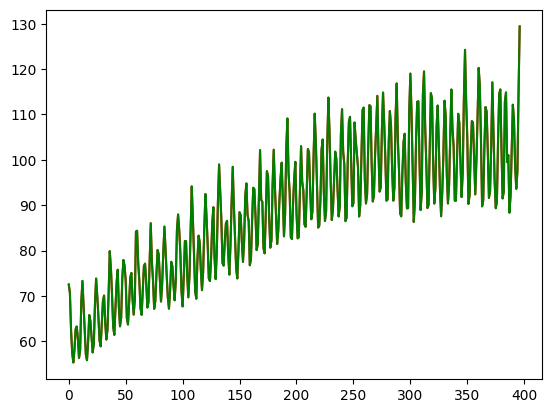

In [5]:
plt.plot(concerned_data.values, color = 'red')
plt.plot(data['Production'].values, color='green')
plt.show()

In [6]:
cd_diffed = concerned_data.diff().dropna()

cd_diffed

1      -1.8332
2      -8.2218
3      -4.9788
4      -2.1563
5       2.7753
        ...   
392   -10.3158
393    -5.0017
394     3.7222
395    17.3853
396    14.6836
Name: Production, Length: 396, dtype: float64

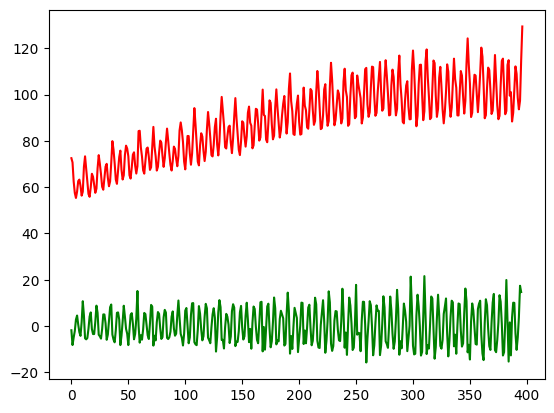

In [7]:
plt.plot(concerned_data.values, color = 'red')
plt.plot(cd_diffed.values, color='green')
plt.show()

In [8]:
adf_test_original = adfuller(concerned_data)
adf_test_diffed = adfuller(cd_diffed)

print(adf_test_original[1], ",", adf_test_diffed[1])

0.18621469116586592 , 4.0777865655394095e-10


In [9]:
def recover_data(original_data, differenced_data):

    last_original_value = original_data.iloc[-len(differenced_data) - 1]

    last_original_value

    recovered_data = differenced_data.cumsum() + last_original_value

    recovered_data.index = data.index[-len(recovered_data):]

    recovered_data = pd.concat([pd.Series(last_original_value, index=[data.index[0]]), recovered_data])

    print(recovered_data)

    plt.plot(original_data.values, color='green')
    plt.plot(recovered_data.values, color='purple')
    plt.show()

    return recovered_data


0       72.5052
1       70.6720
2       62.4502
3       57.4714
4       55.3151
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Length: 397, dtype: float64


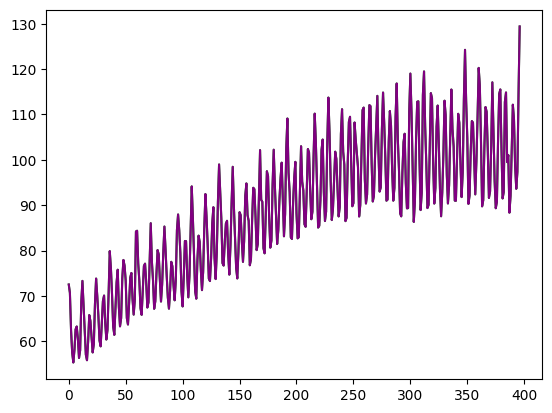

In [10]:
recovered_data = recover_data(concerned_data, cd_diffed)

In [11]:
recovered_data

0       72.5052
1       70.6720
2       62.4502
3       57.4714
4       55.3151
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Length: 397, dtype: float64

--> Thus, we can see that inverse differencing is working perfectly well. So, we will move onto pmdarima, and then, ARIMA

In [12]:
data

,DATE,Production
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [13]:
concerned_data

0       72.5052
1       70.6720
2       62.4502
3       57.4714
4       55.3151
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Name: Production, Length: 397, dtype: float64

In [14]:
cd_diffed

1      -1.8332
2      -8.2218
3      -4.9788
4      -2.1563
5       2.7753
        ...   
392   -10.3158
393    -5.0017
394     3.7222
395    17.3853
396    14.6836
Name: Production, Length: 396, dtype: float64

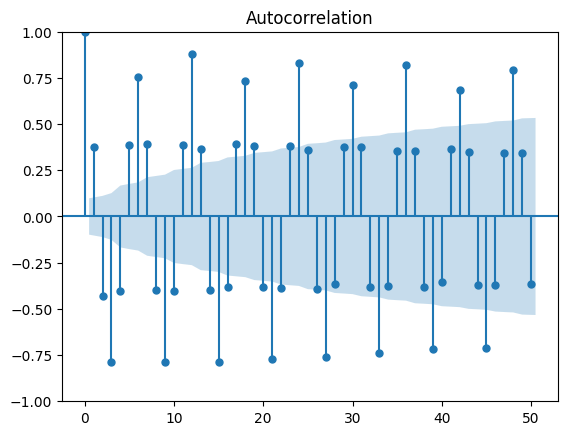

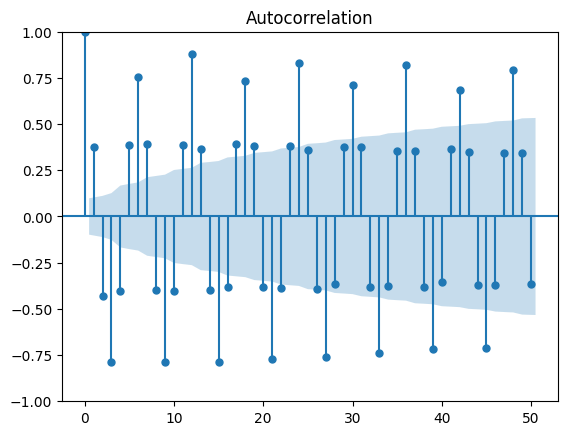

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(cd_diffed.values, lags=50)

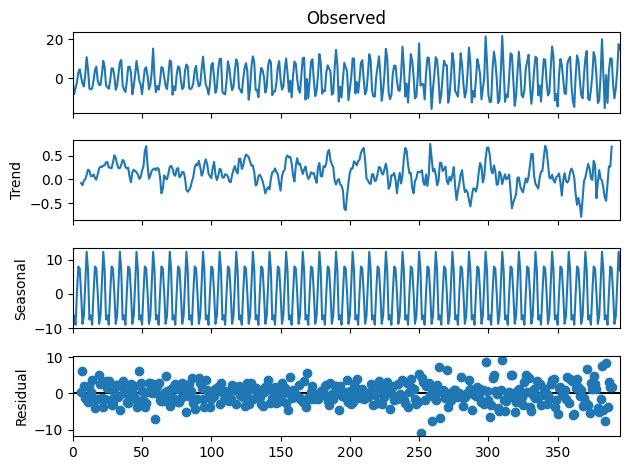

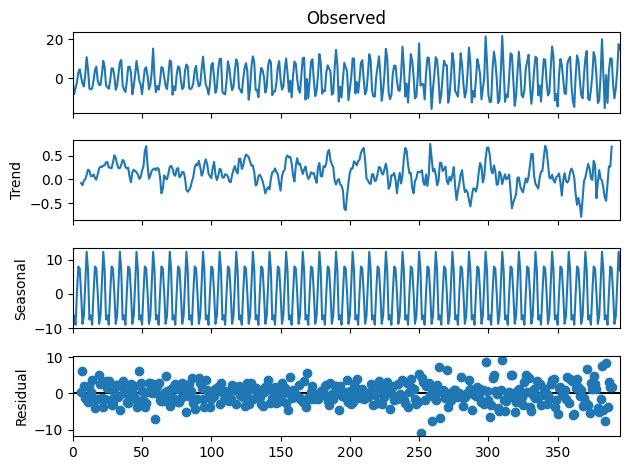

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(cd_diffed.values, model='additive', period=12)  # Use period based on expected seasonality
decomposition.plot()


--> Here, we can see that seasonality is still present

In [17]:
cd_diffed

1      -1.8332
2      -8.2218
3      -4.9788
4      -2.1563
5       2.7753
        ...   
392   -10.3158
393    -5.0017
394     3.7222
395    17.3853
396    14.6836
Name: Production, Length: 396, dtype: float64

In [18]:
X = cd_diffed.iloc[:388]
Y = cd_diffed.iloc[388:]

In [19]:
X

1      -1.8332
2      -8.2218
3      -4.9788
4      -2.1563
5       2.7753
        ...   
384     2.0811
385   -15.3604
386     1.5495
387   -12.6866
388     3.7275
Name: Production, Length: 388, dtype: float64

In [20]:
Y

389    10.0727
390    10.0006
391    -3.2226
392   -10.3158
393    -5.0017
394     3.7222
395    17.3853
396    14.6836
Name: Production, dtype: float64

--> Just Remember:

i. data = original data,
ii. concerned_data = only the production data,
iii. cd_diffed = differenced data for the model,
iv. X = training data,
v. Y = testing data,

In [21]:
stepwise_fit_1 = auto_arima(X.values, seasonal=True, m=12, stepwise=True, trace=True)

C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:1

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1735.100, Time=2.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1955.722, Time=0.01 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1894.169, Time=0.27 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1790.994, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1953.722, Time=0.02 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=1734.321, Time=2.55 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=0.49 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=1734.370, Time=5.04 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=inf, Time=2.48 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=1732.116, Time=5.27 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=1724.894, Time=6.13 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=1723.958, Time=5.15 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=1762.927, Time=4.88 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,1,1)[12] intercept   : AIC=1721.913, Time=4.35 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1733.143, Time=2.12 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,1,0)[12] intercept   : AIC=inf, Time=3.78 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,1,2)[12] intercept   : AIC=1722.011, Time=6.02 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=inf, Time=1.90 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,1,2)[12] intercept   : AIC=1729.671, Time=4.97 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,1,1)[12] intercept   : AIC=1728.742, Time=2.40 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=1721.815, Time=4.00 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1733.326, Time=1.88 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=2.78 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=1722.125, Time=4.45 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=inf, Time=1.47 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=1730.154, Time=5.13 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=1778.183, Time=0.98 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1798.905, Time=0.80 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=1722.377, Time=4.83 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=1813.063, Time=0.58 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=1771.977, Time=1.02 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,1)[12]             : AIC=1725.345, Time=1.28 sec

Best model:  ARIMA(1,0,1)(2,1,1)[12] intercept
Total fit time: 90.263 seconds


In [22]:
stepwise_fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  388
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                -853.907
Date:                            Wed, 08 Jan 2025   AIC                           1721.815
Time:                                    12:04:08   BIC                           1749.322
Sample:                                         0   HQIC                          1732.734
                                            - 388                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0042      0.001     -3.267      0.001      -0.007      -0.002
ar.L1          0.5014      0.046     10.862      0.000       0.411       0.592
ma.L1         -0.9737      0.015    -64.192      0.000      -1.003      -0.944
ar.S.L12      -0.0061      0.074     -0.083      0.934      -0.151       0.138
ar.S.L24      -0.2373      0.061     -3.893      0.000      -0.357      -0.118
ma.S.L12      -0.6853      0.062    -10.967      0.000      -0.808      -0.563
sigma2         5.2835      0.360     14.677      0.000       4.578       5.989
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 9.28
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               2.75   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
model_1 = ARIMA(X.values, order=(1,0,1))
model_1_fit = model_1.fit()

forecast_1 = model_1_fit.forecast(steps = len(Y))

forecast_1

array([8.01798903, 0.51048454, 0.09861728, 0.07602193, 0.07478234,
       0.07471433, 0.0747106 , 0.0747104 ])

In [24]:
Y

389    10.0727
390    10.0006
391    -3.2226
392   -10.3158
393    -5.0017
394     3.7222
395    17.3853
396    14.6836
Name: Production, dtype: float64

In [25]:
mse_1 = mean_squared_error(Y.values, forecast_1)
rmse_1 = sqrt(mse_1)
print(mse_1, rmse_1)

95.68194516532773 9.78171483766153


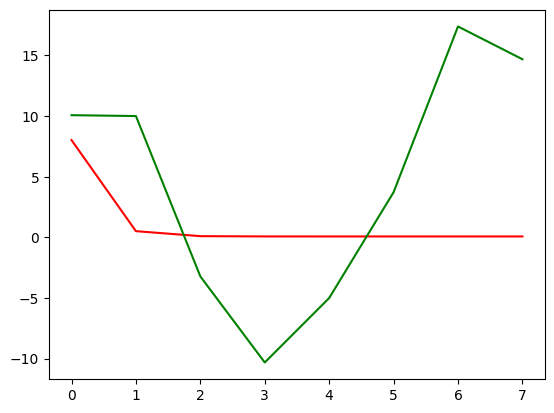

In [26]:
plt.plot(forecast_1, color='red')
plt.plot(Y.values, color='green')
plt.show()

--> As you can see, taking ARIMA with seasonal = True did not work well. So we will try SARIMAX

10.637364033861209 3.261497207397426


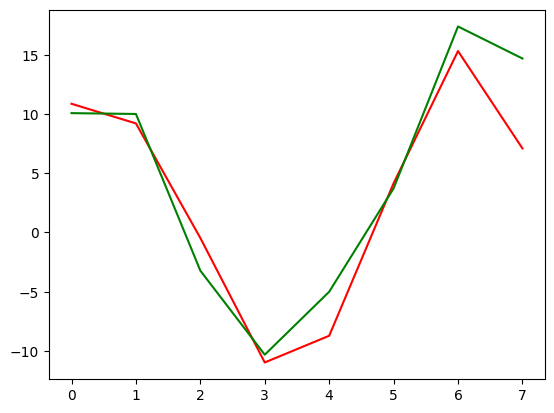

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_2 = SARIMAX(X.values, order=(1,0,1), seasonal_order=(2,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
model_2_fit = model_2.fit()

forecast_2 = model_2_fit.forecast(steps=len(Y))

forecast_2

mse_2 = mean_squared_error(Y.values, forecast_2)
rmse_2 = sqrt(mse_2)
print(mse_2, rmse_2)

plt.plot(forecast_2, color='red')
plt.plot(Y.values, color='green')
plt.show()

--> As you can see, SARIMAX works pretty well when we put seasonal=True in auto arima. Now we will run both the models with seasonal=False, as we will now be relying on the ADF test results.

In [28]:
stepwise_fit_2 = auto_arima(X.values, seasonal=False, m=12, stepwise=True, trace=True)

Performing stepwise search to minimize aic


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecati

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2060.148, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2686.105, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2631.907, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2567.121, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2444.990, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2198.356, Time=0.08 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:1

 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2052.936, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2175.614, Time=0.13 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2045.300, Time=0.47 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=2162.218, Time=0.16 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=2050.221, Time=0.69 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0]             : AIC=2058.692, Time=0.63 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2062.418, Time=0.57 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=2163.243, Time=0.29 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0]             : AIC=inf, Time=0.75 sec


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=2046.164, Time=0.75 sec

Best model:  ARIMA(4,0,2)(0,0,0)[0]          
Total fit time: 5.399 seconds


In [29]:
stepwise_fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  388
Model:               SARIMAX(4, 0, 2)   Log Likelihood               -1015.650
Date:                Wed, 08 Jan 2025   AIC                           2045.300
Time:                        12:04:15   BIC                           2073.027
Sample:                             0   HQIC                          2056.293
                                - 388                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7371      0.045     16.364      0.000       0.649       0.825
ar.L2         -0.9835      0.055    -17.841      0.000      -1.092      -0.875
ar.L3         -0.0164      0.055     -0.298      0.766      -0.125       0.092
ar.L4         -0.2452      0.050     -4.908      0.000      -0.343      -0.147
ma.L1         -0.9466      0.021    -45.444      0.000      -0.987      -0.906
ma.L2          0.9515      0.019     49.434      0.000       0.914       0.989
sigma2        10.6289      0.716     14.850      0.000       9.226      12.032
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

11.575340272063677 3.4022551744488063


C:\Users\Malhar.Pandya\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


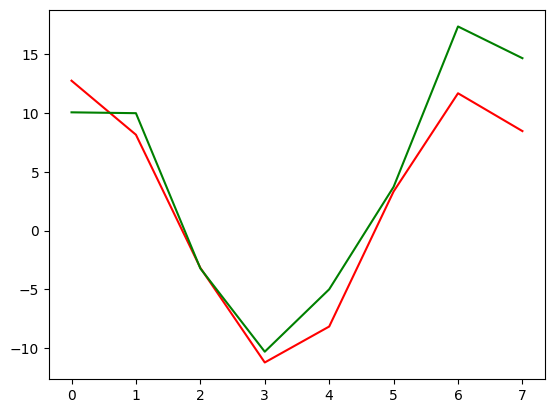

In [30]:
model_3 = ARIMA(X.values, order=(4,0,2))
model_3_fit = model_3.fit()

forecast_3 = model_3_fit.forecast(steps = len(Y))

forecast_3

mse_3 = mean_squared_error(Y.values, forecast_3)
rmse_3 = sqrt(mse_3)
print(mse_3, rmse_3)

plt.plot(forecast_3, color='red')
plt.plot(Y.values, color='green')
plt.show()

11.10224868854749 3.3320037047619695


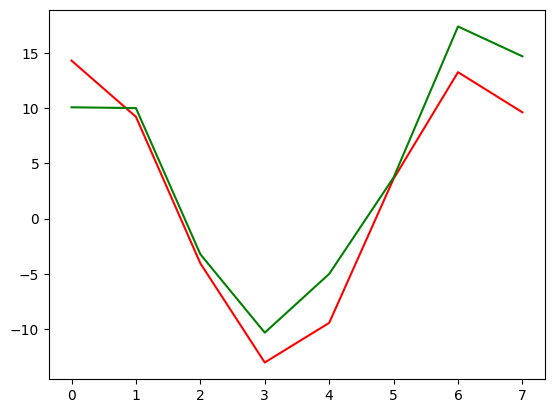

In [31]:
model_4 = SARIMAX(X.values, order=(4,0,2), enforce_stationarity=False, enforce_invertibility=False)
model_4_fit = model_4.fit()

forecast_4 = model_4_fit.forecast(steps = len(Y))

forecast_4

mse_4 = mean_squared_error(Y.values, forecast_4)
rmse_4 = sqrt(mse_4)
print(mse_4, rmse_4)

plt.plot(forecast_4, color='red')
plt.plot(Y.values, color='green')
plt.show()

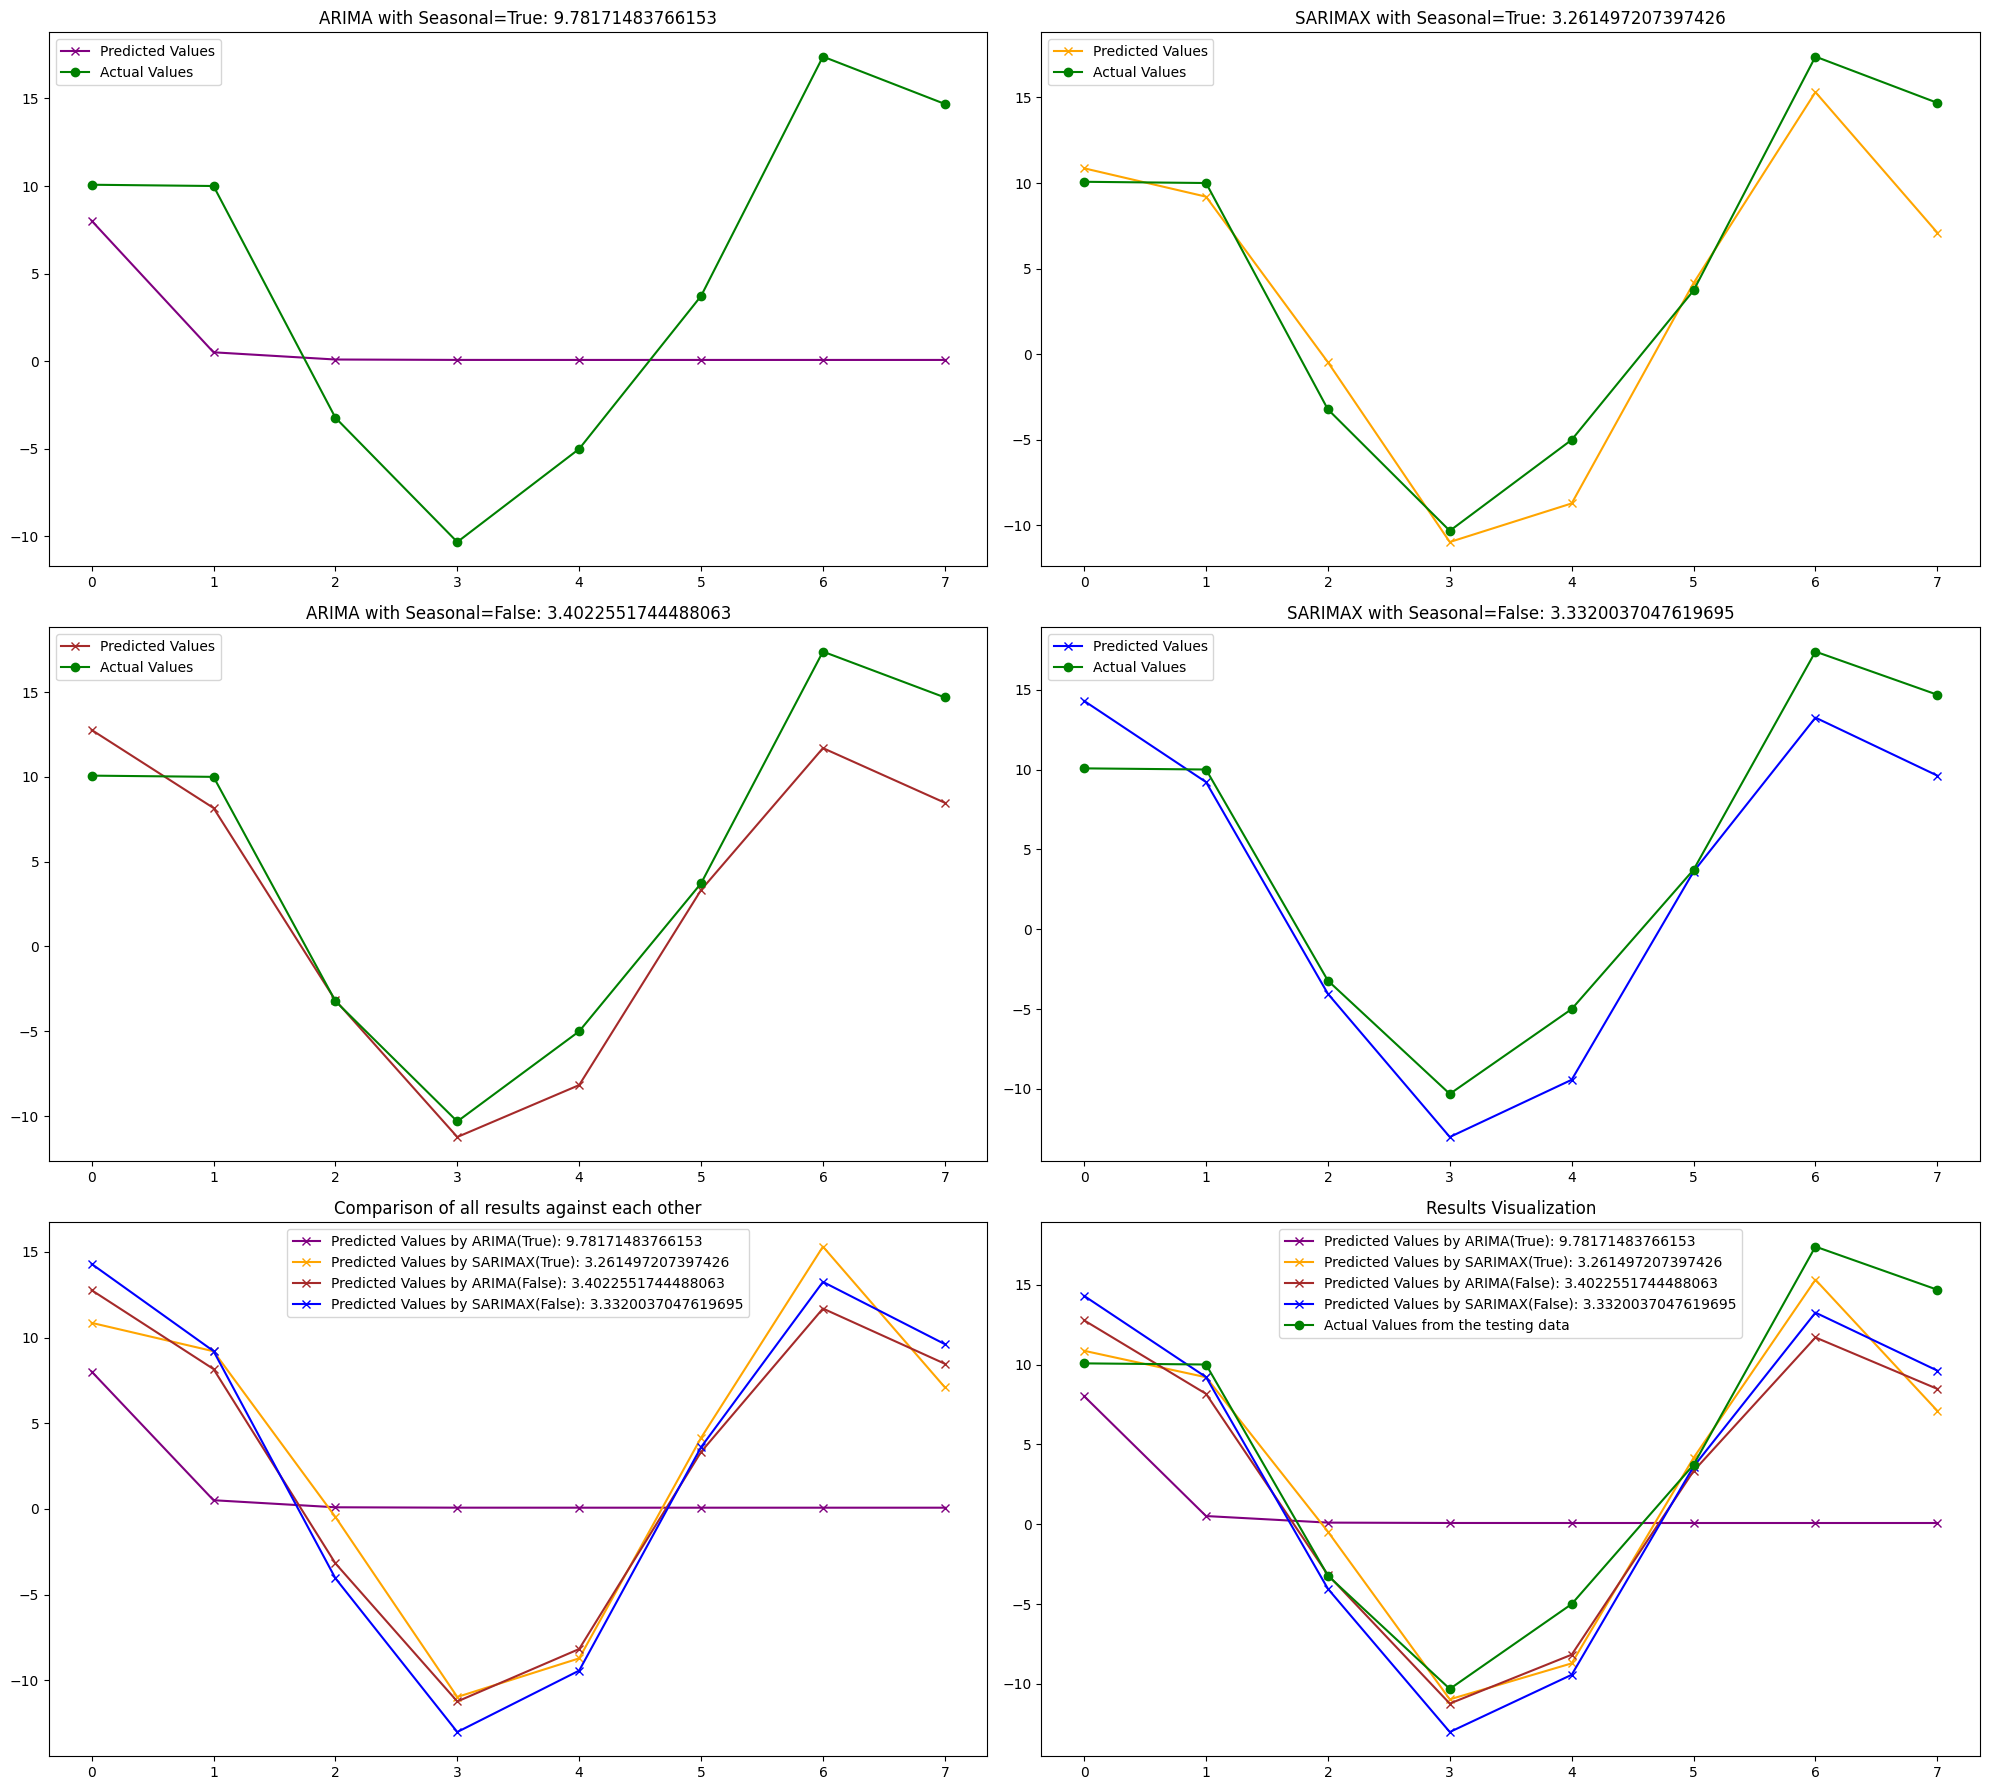

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(20, 18))  # (rows, columns)

axs[0, 0].plot(forecast_1, color='purple', marker='x', label='Predicted Values')
axs[0, 0].plot(Y.values, color='green', marker='o', label='Actual Values')
axs[0, 0].set_title(f'ARIMA with Seasonal=True: {rmse_1}')
axs[0, 0].legend()

axs[0, 1].plot(forecast_2, color='orange', marker='x', label='Predicted Values')
axs[0, 1].plot(Y.values, color='green', marker='o', label='Actual Values')
axs[0, 1].set_title(f'SARIMAX with Seasonal=True: {rmse_2}')
axs[0, 1].legend()

axs[1, 0].plot(forecast_3, color='brown', marker='x', label='Predicted Values')
axs[1, 0].plot(Y.values, color='green', marker='o', label='Actual Values')
axs[1, 0].set_title(f'ARIMA with Seasonal=False: {rmse_3}')
axs[1, 0].legend()

axs[1, 1].plot(forecast_4, color='blue', marker='x', label='Predicted Values')
axs[1, 1].plot(Y.values, color='green', marker='o', label='Actual Values')
axs[1, 1].set_title(f'SARIMAX with Seasonal=False: {rmse_4}')
axs[1, 1].legend()

axs[2, 0].plot(forecast_1, color='purple', marker='x', label=f'Predicted Values by ARIMA(True): {rmse_1}')
axs[2, 0].plot(forecast_2, color='orange', marker='x', label=f'Predicted Values by SARIMAX(True): {rmse_2}')
axs[2, 0].plot(forecast_3, color='brown', marker='x', label=f'Predicted Values by ARIMA(False): {rmse_3}')
axs[2, 0].plot(forecast_4, color='blue', marker='x', label=f'Predicted Values by SARIMAX(False): {rmse_4}')
axs[2, 0].set_title(f'Comparison of all results against each other')
axs[2, 0].legend()

axs[2, 1].plot(forecast_1, color='purple', marker='x', label=f'Predicted Values by ARIMA(True): {rmse_1}')
axs[2, 1].plot(forecast_2, color='orange', marker='x', label=f'Predicted Values by SARIMAX(True): {rmse_2}')
axs[2, 1].plot(forecast_3, color='brown', marker='x', label=f'Predicted Values by ARIMA(False): {rmse_3}')
axs[2, 1].plot(forecast_4, color='blue', marker='x', label=f'Predicted Values by SARIMAX(False): {rmse_4}')
axs[2, 1].plot(Y.values, color='green', marker='o', label='Actual Values from the testing data')
axs[2, 1].set_title(f'Comparison of all results against each other and the Actual Values')
axs[2, 1].legend()

plt.title('Results Visualization')

plt.tight_layout()

plt.show()


--> Therefore, we can see that Seasonal(True) yields the best results. Thus, model = model_2, forecast = forecast_2

0       92.0805
389    102.1532
390    112.1538
391    108.9312
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
dtype: float64


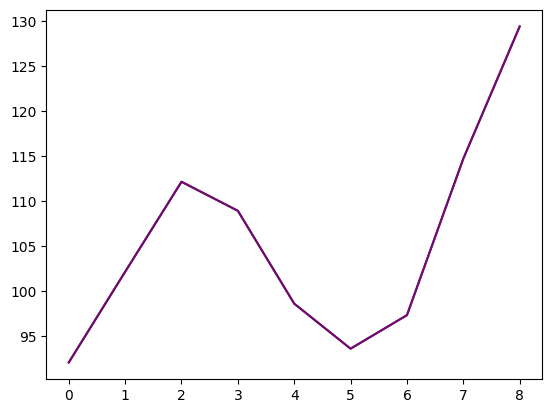

In [33]:
recover_from_test = recover_data(concerned_data[388:], Y)

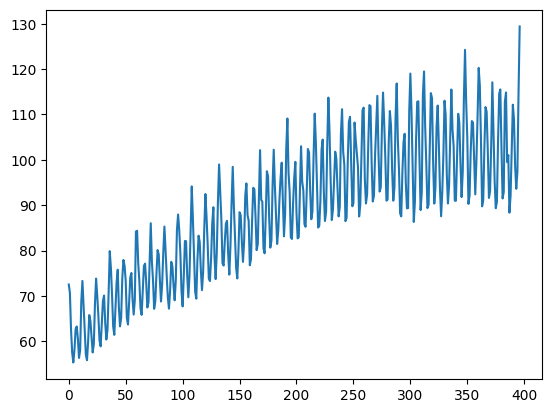

In [34]:
plt.plot(concerned_data)

In [35]:
forecast_2

array([ 10.86067574,   9.20357911,  -0.46640632, -10.9703837 ,
        -8.71624452,   4.15379698,  15.31067671,   7.0987795 ])

In [36]:
concerned_data[388:]

388     92.0805
389    102.1532
390    112.1538
391    108.9312
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Name: Production, dtype: float64

In [37]:
import pandas as pd
import numpy as np

# Create an index starting from 389, with the same length as forecast_2
forecast_index = range(389, 389 + len(forecast_2))

# Convert forecast_2 to a pandas Series with the new index
forecast_series = pd.Series(forecast_2, index=forecast_index)

# Print the transformed forecast
print(forecast_series)


389    10.860676
390     9.203579
391    -0.466406
392   -10.970384
393    -8.716245
394     4.153797
395    15.310677
396     7.098779
dtype: float64


0       92.080500
389    102.941176
390    112.144755
391    111.678349
392    100.707965
393     91.991720
394     96.145517
395    111.456194
396    118.554973
dtype: float64


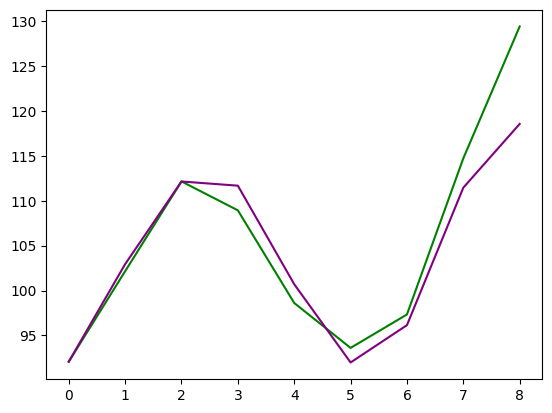

In [38]:
recover_forecasts_from_test = recover_data(concerned_data[388:], forecast_series)

In [39]:
recover_forecasts_from_test

0       92.080500
389    102.941176
390    112.144755
391    111.678349
392    100.707965
393     91.991720
394     96.145517
395    111.456194
396    118.554973
dtype: float64

In [40]:
len(Y)

8

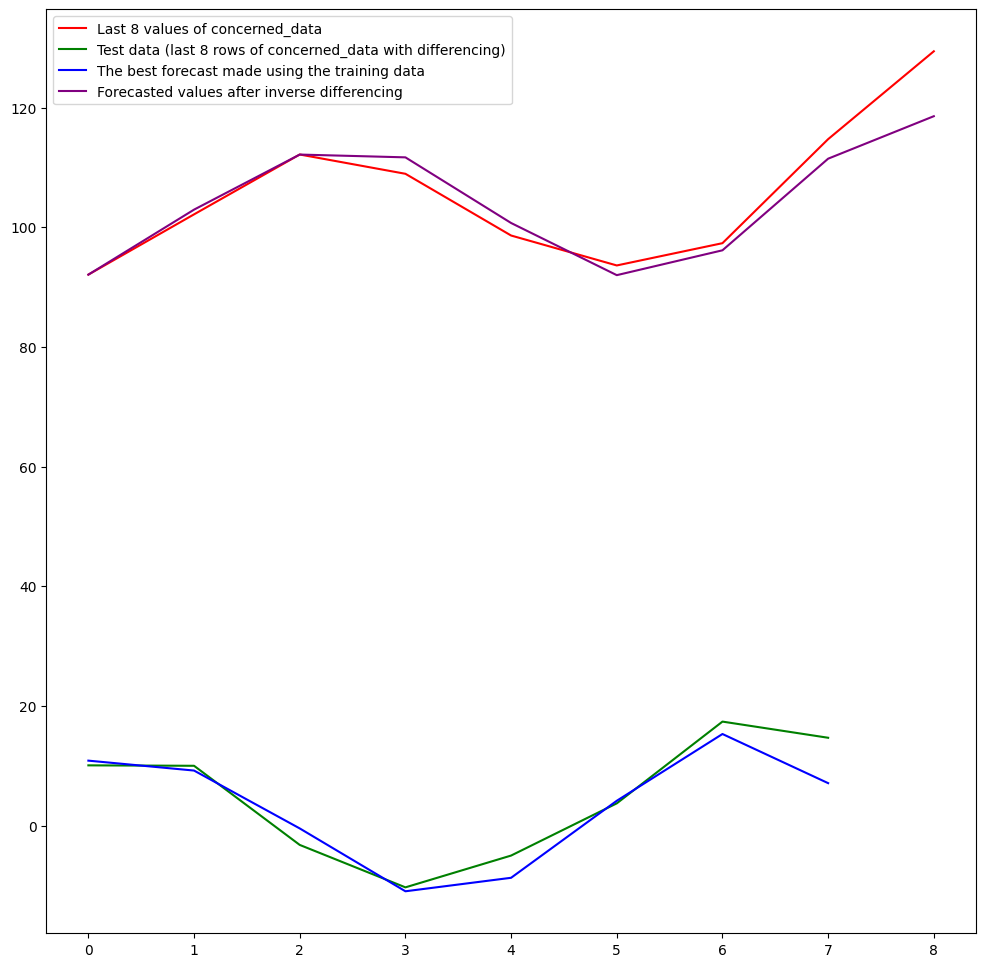

In [41]:
# Therefore, recover_forecasts_from_test = inverse differencing applied on forecasts

plt.figure(figsize=(12, 12))
plt.plot(concerned_data[388:].values, color='red', label='Last 8 values of concerned_data')
plt.plot(Y.values, color='green', label='Test data (last 8 rows of concerned_data with differencing)')
plt.plot(forecast_series.values, color='blue', label='The best forecast made using the training data')
plt.plot(recover_forecasts_from_test.values, color='purple', label='Forecasted values after inverse differencing')
plt.legend()
plt.show()

In [42]:
mse_final = mean_squared_error(concerned_data[388:].values, recover_forecasts_from_test.values)
rmse_final = sqrt(mse_final)
print(mse_final, rmse_final)

16.10816321496189 4.013497628622931


--> Now, we know that the best model has been selected and also that the final results are also good. Thus, we will now make a final predictive system to predict the values 1 year into the future.

--> But, before we begin, we will train a SARIMAX(True) model on the entire difference data

In [43]:
model_final = SARIMAX(cd_diffed.values, order=(1,0,1), seasonal_order=(2,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
model_final_fit = model_final.fit()

In [44]:
forecast_final = model_final_fit.forecast(steps=12)

In [45]:
forecast_final

array([-14.39676504,  -8.61218709, -14.08914069,   1.59603389,
        10.08767684,   8.93625479,  -1.75405725,  -9.70752358,
        -7.66241199,   3.88268282,  13.2385057 ,  12.28293347])

In [46]:
forecast_index = range(397, 397 + len(forecast_final))

# Convert forecast_2 to a pandas Series with the new index
forecast_final_series = pd.Series(forecast_final, index=forecast_index)

# Print the transformed forecast
print(forecast_final_series)

397   -14.396765
398    -8.612187
399   -14.089141
400     1.596034
401    10.087677
402     8.936255
403    -1.754057
404    -9.707524
405    -7.662412
406     3.882683
407    13.238506
408    12.282933
dtype: float64


In [47]:
cd_diffed

1      -1.8332
2      -8.2218
3      -4.9788
4      -2.1563
5       2.7753
        ...   
392   -10.3158
393    -5.0017
394     3.7222
395    17.3853
396    14.6836
Name: Production, Length: 396, dtype: float64

In [48]:
forecast_final_series

397   -14.396765
398    -8.612187
399   -14.089141
400     1.596034
401    10.087677
402     8.936255
403    -1.754057
404    -9.707524
405    -7.662412
406     3.882683
407    13.238506
408    12.282933
dtype: float64

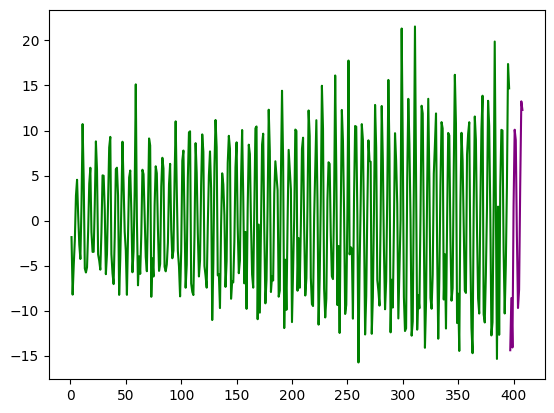

In [49]:
plt.plot(cd_diffed, color='green')
plt.plot(forecast_final_series, color='purple')
plt.show()

In [52]:
concerned_data

0       72.5052
1       70.6720
2       62.4502
3       57.4714
4       55.3151
         ...   
392     98.6154
393     93.6137
394     97.3359
395    114.7212
396    129.4048
Name: Production, Length: 397, dtype: float64

In [54]:
forecast_final_series

397   -14.396765
398    -8.612187
399   -14.089141
400     1.596034
401    10.087677
402     8.936255
403    -1.754057
404    -9.707524
405    -7.662412
406     3.882683
407    13.238506
408    12.282933
dtype: float64

0      114.850500
385    100.453735
386     91.841548
387     77.752407
388     79.348441
389     89.436118
390     98.372373
391     96.618315
392     86.910792
393     79.248380
394     83.131063
395     96.369568
396    108.652502
dtype: float64


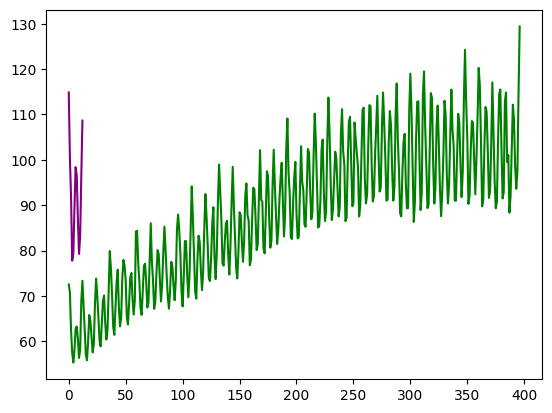

In [57]:
forecast_final = recover_data(concerned_data, forecast_final_series)


In [58]:
forecast_final

0      114.850500
385    100.453735
386     91.841548
387     77.752407
388     79.348441
389     89.436118
390     98.372373
391     96.618315
392     86.910792
393     79.248380
394     83.131063
395     96.369568
396    108.652502
dtype: float64

In [59]:


# Create a new index starting from 397
new_index = range(397, 397 + len(forecast_final))

# Assign the new index to the forecast_final Series
forecast_final.index = new_index

# Print the result with the updated index
print(forecast_final)


397    114.850500
398    100.453735
399     91.841548
400     77.752407
401     79.348441
402     89.436118
403     98.372373
404     96.618315
405     86.910792
406     79.248380
407     83.131063
408     96.369568
409    108.652502
dtype: float64


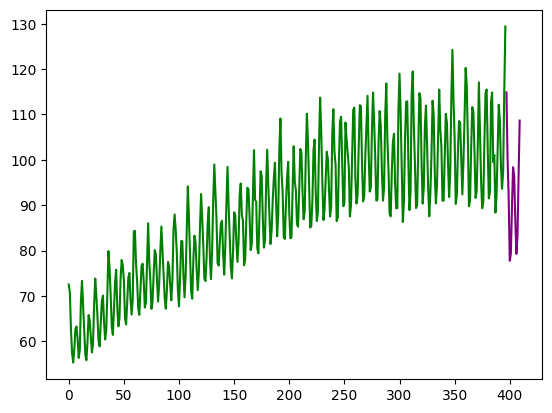

In [61]:
plt.plot(concerned_data, color='green')
plt.plot(forecast_final, color='purple')
plt.show()